# PINNs - Oscilador Harmônico

A EDO de referência é:

$$\left\{\begin{array}{l}
\ddot{x} + \frac{k}{m}x = 0 \\
x(0) = x_0 \\
\dot{x}(0) = v_0
\end{array}\right.$$

Com a solução analítica:

$$x(t) = x_0 \cos\left(\sqrt{\frac{k}{m}} t\right) + v_0 \sqrt{\frac{m}{k}} \sin\left(\sqrt{\frac{k}{m}} t\right)$$

#### Importando Bibliotecas

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch as tc

from torch import nn
from torch.optim.lr_scheduler import StepLR

#### Definindo dados de treino, teste e condição inicial

/tmp/ipykernel_104313/1519414521.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_treino = tc.tensor(novo_t[:split_index])
/tmp/ipykernel_104313/1519414521.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_treino = tc.tensor(novo_x_ref[:split_index])
/tmp/ipykernel_104313/1519414521.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_teste = tc.tensor(novo_t[split_index:])
/tmp/ipykernel_104313/1519414521.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTens

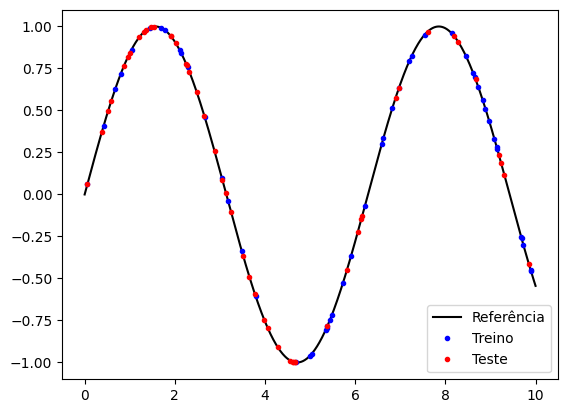

In [24]:
tc.manual_seed(21)

t_i = 0
t_f = 10
n_pontos = 100

train_test_ratio = 0.5

x_0 = 0
v_0 = 1
k = 1
m = 1

t = tc.linspace(t_i, t_f, n_pontos*10)

def x_analitico(t):
    return x_0 * tc.cos(tc.sqrt(tc.tensor(k/m)) * t) + v_0 * tc.sqrt(tc.tensor(m/k)) * tc.sin(tc.sqrt(tc.tensor(k/m)) * t)

x_ref = x_analitico(t)

rand_indices = tc.randint(0, n_pontos*10, (n_pontos,))
novo_t = t[rand_indices]
novo_x_ref = x_ref[rand_indices]

split_index = int(n_pontos*train_test_ratio)
t_treino = tc.tensor(novo_t[:split_index])
x_treino = tc.tensor(novo_x_ref[:split_index])

t_teste = tc.tensor(novo_t[split_index:])
x_teste = tc.tensor(novo_x_ref[split_index:])

condicoes_iniciais = tc.tensor([x_0, v_0])

plt.plot(t, x_ref, 'k-', label='Referência')
plt.plot(t_treino, x_treino, 'b.', label='Treino')
plt.plot(t_teste, x_teste, 'r.', label='Teste')
plt.legend(loc="lower right")
plt.show()


#### Definindo rede neural

In [25]:
class PINN(nn.Module):

    def __init__(self, structure=[1, 10, 10, 1], activation=nn.Tanh()):
        super(PINN, self).__init__()
        self.structure = structure
        self.activation = activation
        self.hidden_layers = nn.ModuleList()

        for i in range(len(structure)-1):
            self.hidden_layers.append(nn.Linear(structure[i], structure[i+1]))
    
    def forward(self, x):
        for layer in self.hidden_layers[:-1]:
            x = self.activation(layer(x))
        x = self.hidden_layers[-1](x) # Sem ativação na última camada
        return x


In [26]:
PINN = PINN(structure=[1, 50, 50, 50, 1])
optimizer = tc.optim.Adam(PINN.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.95)


loss_log = []
epochs = 5000

for epoch in range(epochs):
    t_treino = tc.cat([tc.tensor([0.0]), t_treino], requires_grad = True)
    x_inferencia = PINN(t_treino)

    dx_dt = tc.autograd.grad(x_inferencia, t_treino, create_graph=True)[0]
    d2x_dt2 = tc.autograd.grad(dx_dt, t_treino)[0]  # Sem criar o Grafo

    loss_dados = tc.mean((x_inferencia[1:] - x_treino)**2) # Supervisionado
    loss_EDP = tc.mean((d2x_dt2 + tc.tensor(k/m)*x_inferencia)**2) # EDP
    loss_CI = (x_inferencia[0] - condicoes_iniciais[0])**2 + (dx_dt[0] - condicoes_iniciais[1])**2 # Condições iniciais
    loss = loss_dados + loss_EDP + loss_CI

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    scheduler.step()

    loss_log.append([loss.item(), loss_dados.item(), loss_EDP.item(), loss_CI.item()])


plt.plot(LOSS)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

TypeError: cat() received an invalid combination of arguments - got (list, requires_grad=bool), but expected one of:
 * (tuple of Tensors tensors, int dim = 0, *, Tensor out = None)
 * (tuple of Tensors tensors, name dim, *, Tensor out = None)
